In [157]:
# data processing libraries
import pandas as pd
import numpy as np
from IPython.display import Markdown, display, Image

# modeling 
import sklearn
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import SimpleImputer

# Algorithms
import statsmodels.api as sm
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split

# Causal Inference
import causalml
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseRClassifier, BaseXClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from causalml.dataset import *
from causalml.metrics import *


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5] #change size of plot
plt.style.use('fivethirtyeight')


# Handle warnings
import warnings
warnings.filterwarnings('ignore')

print(causalml.__version__)

0.13.0


# Load Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction/main/Data/df5.csv'
data = pd.read_csv(url)
data

In [7]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [8]:
list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more t

We consider rating=0 as missing values as the customer did not provide any rating feedback.

In [10]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                 67
Departure/Arrival_time_convenient    134
Ease_of_Online_booking                58
Online_boarding                       16
Leg_room_service                       1
dtype: int64

In [11]:
(data[incomplete] == 0).sum().sum()/data.shape[0]

0.00627857776564526

Considering the total number of rows that contains missing ratings only takes up 0.6% of the dataset, we simply drop these observations.

In [12]:
data = data.loc[(data[incomplete] != 0).all(axis=1)]

list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more than 22 values
satisfactio

We are interested in which features about the flight would cause customer satisfactory / unsatisfactory. Hence we will not consider information about  
- Customer: 'Age', 'Gender_Male', 'Customer_Type_Loyal Customer', 
- Class: 'Class' and 'Type_of_Travel_Business travel'. 
- 'Flight_Distance', 'Departure_Delay_in_Minutes': Most of the time it is out of our control.

In [63]:
data_causal = data.drop(columns={'Age', 'Gender_Male', 
                       'Customer_Type_Loyal Customer', 'Class', 
                       'Type_of_Travel_Business travel',
                       'Flight_Distance', 'Departure_Delay_in_Minutes'} )
data_causal.columns

Index(['Inflight_wifi_service', 'Departure/Arrival_time_convenient',
       'Ease_of_Online_booking', 'Gate_location', 'Food_and_drink',
       'Online_boarding', 'Seat_comfort', 'Inflight_entertainment',
       'On-board_service', 'Leg_room_service', 'Baggage_handling',
       'Checkin_service', 'Inflight_service', 'Cleanliness', 'satisfaction'],
      dtype='object')

For each feature, we want to answer the question "What if we provide better service for this feature, will my satisfication level increase?"

We consider rating larger than 3 as good enough service, and rating less or equal than 3 as need to improve.

In [64]:
# Convert all features into boolean
feature_names = data_causal.drop(columns='satisfaction').columns

data_causal[feature_names] = data_causal[feature_names].applymap(lambda x: 1 if x > 3 else 0)
data_causal.head

<bound method NDFrame.head of        Inflight_wifi_service  Departure/Arrival_time_convenient  \
0                          0                                  0   
1                          0                                  0   
2                          0                                  1   
3                          1                                  0   
4                          0                                  0   
...                      ...                                ...   
43954                      1                                  1   
43955                      1                                  1   
43956                      1                                  1   
43957                      0                                  0   
43958                      1                                  1   

       Ease_of_Online_booking  Gate_location  Food_and_drink  Online_boarding  \
0                           0              0               1                1   
1  

# Feature Importance

In [65]:
X = data_causal.drop(columns='satisfaction')
y = data_causal['satisfaction']

In [91]:
col_names = X.columns
col_names

Index(['Inflight_wifi_service', 'Departure/Arrival_time_convenient',
       'Ease_of_Online_booking', 'Gate_location', 'Food_and_drink',
       'Online_boarding', 'Seat_comfort', 'Inflight_entertainment',
       'On-board_service', 'Leg_room_service', 'Baggage_handling',
       'Checkin_service', 'Inflight_service', 'Cleanliness'],
      dtype='object')

In [58]:
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

lgbm_clf = LGBMClassifier(n_estimators=1000, 
                          n_jobs=1,
                          learning_rate=0.02,
                          num_leaves=50,
                          max_depth=7,
                          verbose=-1,
                          random_state=42)
model_lgbm= lgbm_clf.fit(X, y)

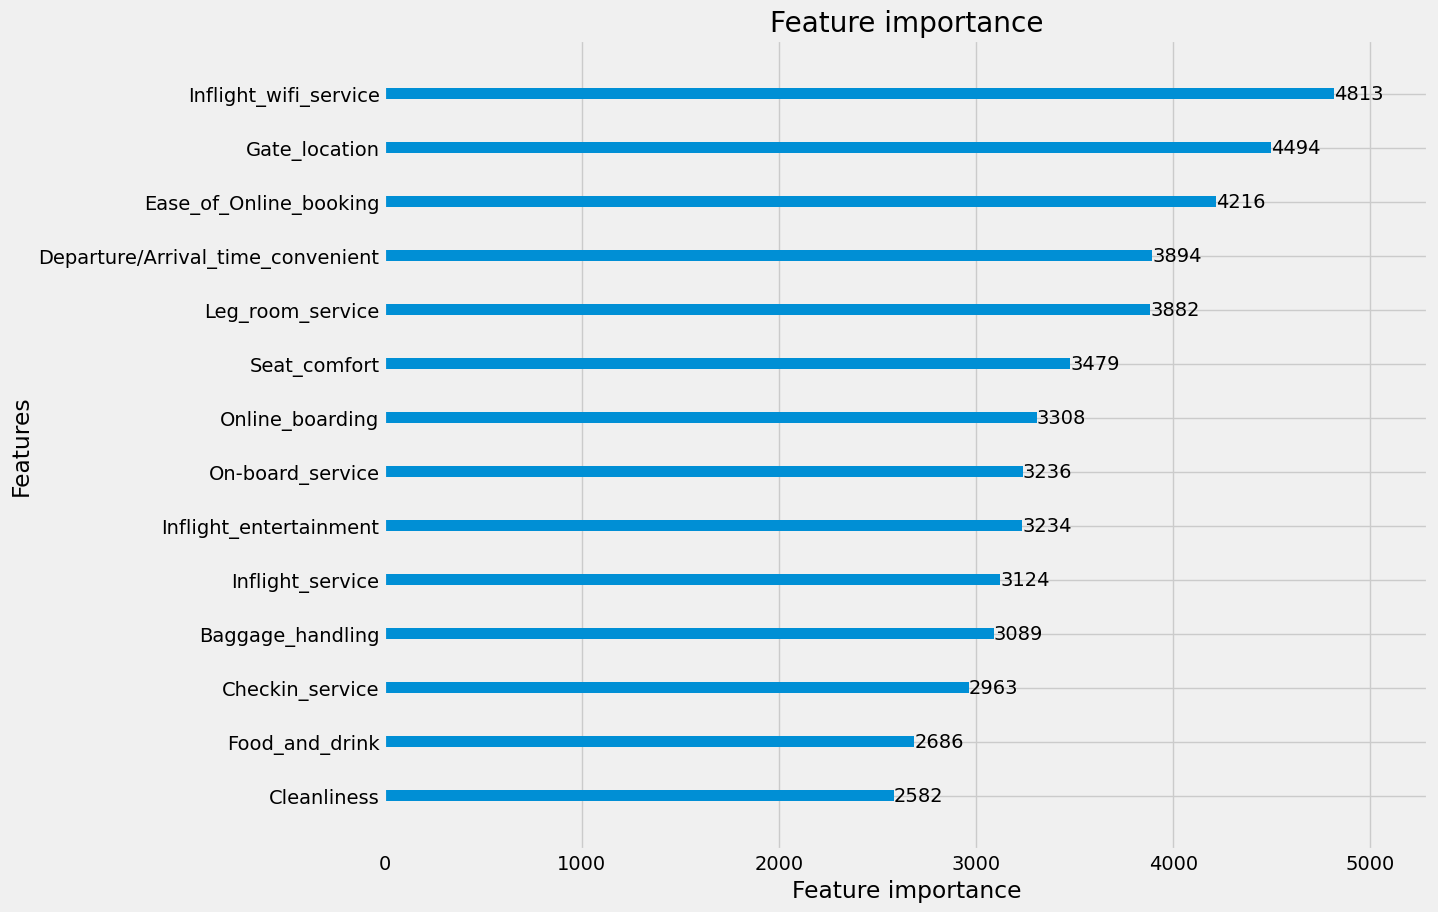

In [59]:
lgb.plot_importance(model_lgbm)
plt.rcParams['figure.figsize'] = [12, 10]
plt.show()

We want to see if the feature with high feature importance actually has high causal effect as well

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [167]:
treatment = X_train['Seat_comfort']
treatment

15780    1
40434    1
22418    1
32665    0
34191    0
        ..
40392    1
37121    0
4839     1
10234    1
12161    1
Name: Seat_comfort, Length: 35004, dtype: int64

In [168]:
X_train.columns

Index(['Inflight_wifi_service', 'Departure/Arrival_time_convenient',
       'Ease_of_Online_booking', 'Gate_location', 'Food_and_drink',
       'Online_boarding', 'Seat_comfort', 'Inflight_entertainment',
       'On-board_service', 'Leg_room_service', 'Baggage_handling',
       'Checkin_service', 'Inflight_service', 'Cleanliness'],
      dtype='object')

# S-Learner

In [118]:
#  using XGBCLassifier
s_learner = BaseSClassifier(XGBClassifier(random_state=42))
S_ATE_XGB = []
print('Avereage Treatment Effect with S-Learner using XGBClassifer\n')

y_c = X_train['satisfaction']
for c in col_names:
    treatment = X_train[c]
    X_c = X_train.drop(columns={c,'satisfaction'})

    ate, lb, ub = s_learner.estimate_ate(X=X_c, treatment=treatment, y=y_c, return_ci=True)
    S_ATE_XGB.append(ate[0])
    print(c,': {:.2f} ({:.2f}, {:.2f})'.format(ate[0],lb[0], ub[0]))


Avereage Treatment Effect with S-Learner using XGBClassifer

Inflight_wifi_service : 0.14 (0.13, 0.14)
Departure/Arrival_time_convenient : -0.07 (-0.08, -0.07)
Ease_of_Online_booking : -0.03 (-0.04, -0.03)
Gate_location : 0.03 (0.02, 0.04)
Food_and_drink : 0.02 (0.02, 0.03)
Online_boarding : 0.26 (0.25, 0.26)
Seat_comfort : 0.07 (0.06, 0.07)
Inflight_entertainment : 0.04 (0.04, 0.05)
On-board_service : 0.04 (0.04, 0.05)
Leg_room_service : 0.19 (0.18, 0.19)
Baggage_handling : 0.06 (0.05, 0.06)
Checkin_service : 0.03 (0.03, 0.03)
Inflight_service : 0.07 (0.06, 0.07)
Cleanliness : 0.04 (0.03, 0.04)


In [119]:
#  using LGBMCLassifier
s_learner = BaseSClassifier(LGBMClassifier(random_state=42))
S_ATE_LGBM = []
print('Avereage Treatment Effect with S-Learner using LGBMClassifer\n')

y_c = X_train['satisfaction']
for c in col_names:
    treatment = X_train[c]
    X_c = X_train.drop(columns={c,'satisfaction'})

    ate, lb, ub = s_learner.estimate_ate(X=X_c, treatment=treatment, y=y_c, return_ci=True)
    S_ATE_LGBM.append(ate[0])
    print(c,': {:.2f} ({:.2f}, {:.2f})'.format(ate[0],lb[0], ub[0]))


Avereage Treatment Effect with S-Learner using LGBMClassifer

Inflight_wifi_service : 0.12 (0.12, 0.13)
Departure/Arrival_time_convenient : -0.08 (-0.09, -0.08)
Ease_of_Online_booking : -0.03 (-0.03, -0.02)
Gate_location : 0.05 (0.05, 0.06)
Food_and_drink : -0.00 (-0.01, 0.00)
Online_boarding : 0.26 (0.25, 0.26)
Seat_comfort : 0.07 (0.07, 0.08)
Inflight_entertainment : 0.03 (0.03, 0.03)
On-board_service : 0.04 (0.04, 0.05)
Leg_room_service : 0.19 (0.18, 0.19)
Baggage_handling : 0.05 (0.05, 0.06)
Checkin_service : 0.03 (0.03, 0.04)
Inflight_service : 0.05 (0.05, 0.06)
Cleanliness : 0.03 (0.03, 0.04)


# T-Learner

In [141]:
#  using XGBCLassifier
t_learner = BaseTClassifier(XGBClassifier(random_state=42))
T_ATE_XGB = []
print('Avereage Treatment Effect with T-Learner using XGBClassifer\n')

y_c = X_train['satisfaction']
for c in col_names:
    treatment = X_train[c]
    X_c = X_train.drop(columns={c,'satisfaction'})

    ate, lb, ub = t_learner.estimate_ate(X=X_c, treatment=treatment, y=y_c)
    T_ATE_XGB.append(ate[0])
    print(c,': {:.2f} ({:.2f}, {:.2f})'.format(ate[0],lb[0], ub[0]))


Avereage Treatment Effect with T-Learner using XGBClassifer

Inflight_wifi_service : 0.14 (0.13, 0.14)
Departure/Arrival_time_convenient : -0.07 (-0.08, -0.07)
Ease_of_Online_booking : -0.02 (-0.03, -0.02)
Gate_location : -0.16 (-0.17, -0.15)
Food_and_drink : 0.03 (0.02, 0.03)
Online_boarding : 0.27 (0.27, 0.28)
Seat_comfort : 0.07 (0.07, 0.08)
Inflight_entertainment : 0.04 (0.04, 0.05)
On-board_service : 0.10 (0.10, 0.11)
Leg_room_service : 0.19 (0.18, 0.19)
Baggage_handling : 0.06 (0.06, 0.07)
Checkin_service : 0.03 (0.03, 0.04)
Inflight_service : 0.07 (0.07, 0.08)
Cleanliness : 0.06 (0.06, 0.07)


In [122]:
#  using LGBMCLassifier
t_learner = BaseTClassifier(LGBMClassifier(random_state=42))
T_ATE_LGBM = []
print('Avereage Treatment Effect with T-Learner using LGBMClassifer\n')

y_c = X_train['satisfaction']
for c in col_names:
    treatment = X_train[c]
    X_c = X_train.drop(columns={c,'satisfaction'})

    ate, lb, ub = t_learner.estimate_ate(X=X_c, treatment=treatment, y=y_c)
    T_ATE_LGBM.append(ate[0])
    print(c,': {:.2f} ({:.2f}, {:.2f})'.format(ate[0],lb[0], ub[0]))


Avereage Treatment Effect with T-Learner using LGBMClassifer

Inflight_wifi_service : 0.14 (0.13, 0.15)
Departure/Arrival_time_convenient : -0.08 (-0.08, -0.07)
Ease_of_Online_booking : -0.03 (-0.03, -0.02)
Gate_location : -0.15 (-0.16, -0.14)
Food_and_drink : 0.01 (0.01, 0.02)
Online_boarding : 0.28 (0.27, 0.28)
Seat_comfort : 0.08 (0.07, 0.08)
Inflight_entertainment : 0.05 (0.04, 0.05)
On-board_service : 0.05 (0.05, 0.06)
Leg_room_service : 0.20 (0.19, 0.21)
Baggage_handling : 0.06 (0.06, 0.07)
Checkin_service : 0.03 (0.03, 0.04)
Inflight_service : 0.09 (0.08, 0.09)
Cleanliness : 0.07 (0.06, 0.07)


# X-Learner

In [161]:
# using LGBMCLassifier
x_learner = BaseXClassifier(outcome_learner=XGBClassifier(),
                            control_outcome_learner=XGBClassifier(),
                            treatment_outcome_learner=XGBClassifier(),
                            control_effect_learner=XGBRegressor(),
                            treatment_effect_learner=XGBRegressor())
X_ATE_XGB = []
print('Avereage Treatment Effect with X-Learner using XGBClassifer\n')

y_c = X_train['satisfaction']
for c in col_names:
    treatment = X_train[c]
    X_c = X_train.drop(columns={c,'satisfaction'})

    ate, lb, ub = x_learner.estimate_ate(X=X_c, treatment=treatment, y=y_c)
    X_ATE_XGB.append(ate[0])
    print(c,': {:.2f} ({:.2f}, {:.2f})'.format(ate[0],lb[0], ub[0]))


Avereage Treatment Effect with X-Learner using XGBClassifer

Inflight_wifi_service : 0.16 (0.15, 0.17)
Departure/Arrival_time_convenient : -0.07 (-0.07, -0.06)
Ease_of_Online_booking : -0.03 (-0.04, -0.03)
Gate_location : -0.16 (-0.16, -0.15)
Food_and_drink : 0.05 (0.05, 0.06)
Online_boarding : 0.28 (0.27, 0.28)
Seat_comfort : 0.07 (0.07, 0.08)
Inflight_entertainment : 0.07 (0.07, 0.08)
On-board_service : 0.09 (0.09, 0.10)
Leg_room_service : 0.18 (0.18, 0.19)
Baggage_handling : 0.06 (0.05, 0.06)
Checkin_service : 0.03 (0.03, 0.03)
Inflight_service : 0.08 (0.08, 0.09)
Cleanliness : 0.03 (0.02, 0.03)


In [162]:
# using LGBMCLassifier
x_learner = BaseXClassifier(outcome_learner=LGBMClassifier(),
                            control_outcome_learner=LGBMClassifier(),
                            treatment_outcome_learner=LGBMClassifier(),
                            control_effect_learner=LGBMRegressor(),
                            treatment_effect_learner=LGBMRegressor())
X_ATE_LGBM = []
print('Avereage Treatment Effect with X-Learner using LGBMClassifer\n')

y_c = X_train['satisfaction']
for c in col_names:
    treatment = X_train[c]
    X_c = X_train.drop(columns={c,'satisfaction'})

    ate, lb, ub = x_learner.estimate_ate(X=X_c, treatment=treatment, y=y_c)
    X_ATE_LGBM.append(ate[0])
    print(c,': {:.2f} ({:.2f}, {:.2f})'.format(ate[0],lb[0], ub[0]))


Avereage Treatment Effect with X-Learner using LGBMClassifer

Inflight_wifi_service : 0.13 (0.12, 0.14)
Departure/Arrival_time_convenient : -0.08 (-0.08, -0.07)
Ease_of_Online_booking : -0.06 (-0.06, -0.05)
Gate_location : -0.08 (-0.09, -0.08)
Food_and_drink : 0.02 (0.01, 0.02)
Online_boarding : 0.26 (0.25, 0.26)
Seat_comfort : 0.07 (0.07, 0.08)
Inflight_entertainment : 0.10 (0.09, 0.10)
On-board_service : 0.06 (0.06, 0.07)
Leg_room_service : 0.19 (0.19, 0.20)
Baggage_handling : 0.07 (0.06, 0.08)
Checkin_service : 0.03 (0.03, 0.04)
Inflight_service : 0.08 (0.08, 0.09)
Cleanliness : 0.06 (0.06, 0.07)


Combine all results for comparison

In [163]:
df_causal_result = pd.DataFrame.from_dict(
    {
        #'Treatment':col_names,
        'S_XGB': S_ATE_XGB,
        'S_LGBM': S_ATE_LGBM,
        'T_XGB': T_ATE_XGB,
        'T_LGBM': T_ATE_LGBM,
        'X_XGB': X_ATE_XGB,
        'X_LGBM': X_ATE_LGBM
    }
)

df_causal_result = df_causal_result.set_index(col_names)

In [164]:
df_causal_result.sort_values(by='S_XGB', ascending=False)

,S_XGB,S_LGBM,T_XGB,T_LGBM,X_XGB,X_LGBM
Online_boarding,0.258802,0.258016,0.271282,0.275503,0.278783,0.257628
Leg_room_service,0.186065,0.186754,0.186462,0.200307,0.182332,0.194893
Inflight_wifi_service,0.135552,0.124671,0.136079,0.139548,0.163139,0.130431
Seat_comfort,0.068309,0.071497,0.074150,0.077359,0.070638,0.072008
Inflight_service,0.067779,0.054140,0.074421,0.085553,0.082518,0.082022
Baggage_handling,0.055244,0.050394,0.063791,0.063302,0.057744,0.069950
On-board_service,0.041960,0.041370,0.100989,0.050939,0.090946,0.064237
Inflight_entertainment,0.040840,0.029861,0.042522,0.049393,0.071396,0.095345
Cleanliness,0.038111,0.031009,0.062200,0.069225,0.029397,0.063406
Checkin_service,0.030684,0.031199,0.031357,0.032203,0.030804,0.031599


The learners' results are nearly identical, with Online_boarding showing the greatest ATE, trailed by Leg_room_service and Inflight_wifi_service. To boost customer satisfaction, the airline ought to concentrate on enhancing their performance in these areas of service.